In [4]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from Bio import Phylo
import io
from tqdm import tqdm

In [5]:
class Node:
    def __init__(self, value: np.ndarray, parent: "Node | None"):
        """
        value: length N array of ints
        """

        self.name = ""
        self.value = value
        self.parent = parent

        # will be populated with only the non-pruned nodes in the tree
        self.children = set[Node]()

    def set_name(self, name: str):
        self.name = name

    def add_child(self, child: "Node"):
        self.children.add(child)

    def add_child_up_to_root(self):
        """
        Populates the children field for all nodes up to the root
        """

        if self.parent:
            self.parent.add_child(self)
            self.parent.add_child_up_to_root()

    def get_human_readable_value(self):
        # fmt: off
        value_to_base = [
            "AA", "CC", "GG", "TT",
            "AC", "AG", "AT", "CG",
            "CT", "GT", "CA", "GA",
            "TA", "GC", "TC", "TG",
        ]
        # fmt: on
        return "|".join([value_to_base[v] for v in self.value])

    def get_phy_value(self, human_readable=False):
        # fmt: off
        value_to_base = [
            "A", "C", "G", "T",
            # represent as unphased
            "M", "R", "W", "S", "Y", "K",
            "M", "R", "W", "S", "Y", "K",
        ]
        # fmt: on

        return "".join([value_to_base[v] for v in self.value])

    def get_newick_tree(self) -> str:
        if len(self.children) == 0:
            return self.name
        else:
            return f"({','.join([child.get_newick_tree() for child in self.children])}){self.name}"


class Simulate_GT16:
    def __init__(
        self,
        exchangeability: np.ndarray,
        stationary: np.ndarray,
        *,
        N=500,
        pool_size=20,
        final_leaf_count=20,
        child_sample_count=10,
        dt=1,
        sim_steps=10,
    ):
        """
        exchangeability: length 6
        stationary: length 16
        N: number of sites
        """

        self.pi = exchangeability
        self.stat = stationary
        self.N = N
        self.pool_size = pool_size
        self.final_leaf_count = final_leaf_count
        self.child_sample_count = child_sample_count
        self.dt = dt
        self.sim_steps = sim_steps

        self.A = 16

        self.Q = self.get_Q()
        self.plot_Q()

        self.dummy_root_cell, self.healthy_cell, self.leaf_cells = self.simulate()
        self.newick_tree = self.get_newick_tree()

    def get_Q(self):
        pi8 = np.repeat(self.pi, 8)

        # index helpers for Q matrix
        AA, CC, GG, TT, AC, AG, AT, CG, CT, GT, CA, GA, TA, GC, TC, TG = range(self.A)

        # fmt: off
        updates = [
          # | first base changes                    | second base changes
            [AA, CA], [AC, CC], [AG, CG], [AT, CT], [AA, AC], [CA, CC], [GA, GC], [TA, TC], # A->C
            [AA, GA], [AC, GC], [AG, GG], [AT, GT], [AA, AG], [CA, CG], [GA, GG], [TA, TG], # A->G
            [AA, TA], [AC, TC], [AG, TG], [AT, TT], [AA, AT], [CA, CT], [GA, GT], [TA, TT], # A->T
            [CA, GA], [CC, GC], [CG, GG], [CT, GT], [AC, AG], [CC, CG], [GC, GG], [TC, TG], # C->G
            [CA, TA], [CC, TC], [CG, TG], [CT, TT], [AC, AT], [CC, CT], [GC, GT], [TC, TT], # C->T
            [GA, TA], [GC, TC], [GG, TG], [GT, TT], [AG, AT], [CG, CT], [GG, GT], [TG, TT], # G->T
        ]
        # fmt: on

        R = np.zeros((self.A, self.A))

        for update, pi_val in zip(updates, pi8):
            R[update[0], update[1]] = pi_val

        R = R + R.T

        y_q = R @ np.diag(self.stat)
        hyphens = np.sum(y_q, axis=1)
        Q = np.copy(y_q)
        np.fill_diagonal(Q, -hyphens)
        return Q

    def plot_Q(self):
        plt.title("Q matrix used for simulation")
        plt.imshow(self.Q)
        plt.show()

    def sample(self, probabilities: np.ndarray):
        """
        probabilities: length A
        """

        normalized_probabilities = probabilities / np.sum(probabilities)
        return np.random.choice(self.A, p=normalized_probabilities)

    def probabilities_to_cell(self, probabilities: np.ndarray, parent: Node | None):
        """
        probabilities: N x A
        """

        sampled_value = np.apply_along_axis(self.sample, 1, probabilities)
        return Node(sampled_value, parent)

    def evolve_cell(self, cell: Node):
        # expand length N array cell.value into N x A array of one-hot vectors
        value_one_hot = np.eye(self.A)[cell.value]

        probabilities = scipy.linalg.expm(self.Q * self.dt) @ value_one_hot.T  # A x N
        probabilities = probabilities.T  # N x A
        return self.probabilities_to_cell(probabilities, cell)

    def simulate(self) -> tuple[Node, Node, list[Node]]:
        probabilities_across_sites = np.tile(self.stat, (self.N, 1))

        dummy_root_cell = Node(np.zeros(self.N, dtype=int), None)

        pool = [
            self.probabilities_to_cell(probabilities_across_sites, dummy_root_cell)
            for _ in range(self.pool_size)
        ]

        healthy_cell = pool[0]

        for _ in tqdm(range(self.sim_steps)):
            new_pool = []

            for cell in pool:
                for _ in range(self.child_sample_count):
                    new_pool.append(self.evolve_cell(cell))

            pool = np.random.choice(new_pool, size=self.pool_size, replace=False)

        leaf_cells = np.random.choice(pool, size=self.final_leaf_count, replace=False)  # type: ignore

        dummy_root_cell.set_name("Dummy")
        healthy_cell.set_name("Healthy")

        for i, cell in enumerate(leaf_cells):
            cell.set_name(f"CELL-{i}")

        return dummy_root_cell, healthy_cell, list(leaf_cells)

    def get_newick_tree(self) -> str:
        # add relevant children to each node
        for cell in [self.healthy_cell] + self.leaf_cells:
            cell.add_child_up_to_root()

        return self.dummy_root_cell.get_newick_tree()

    def save_to_dot_phy(self, path: str):
        total_cells = self.final_leaf_count + 1  # including healthy cell

        with open(path, "w") as f:
            f.write(f"{total_cells} {self.N}\n")

            for cell in [self.healthy_cell] + self.leaf_cells:
                f.write(f"{cell.name}    {cell.get_phy_value()}\n")

exchangeability: [0.04061526 0.03384214 0.03021603 0.0557263  0.04098368 0.03388412]
stationary: [0.55160588 0.56206344 0.89842033 0.7531591  0.13221997 0.18103906
 0.72723626 0.88618747 0.85427593 0.07438329 0.36344647 0.20042378
 0.06933757 0.63204624 0.14966574 0.4612379 ]


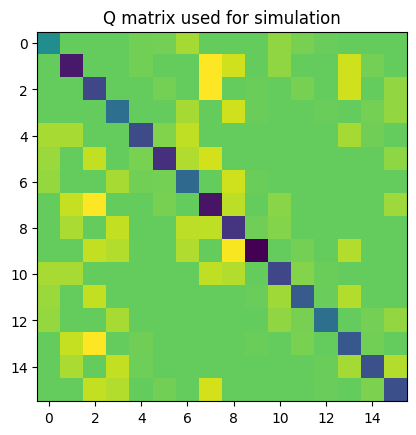

100%|██████████| 30/30 [00:47<00:00,  1.58s/it]


Newick tree: (((((((((((((((((((((((((((((((CELL-10))))))))))))),(((((((((((((CELL-14))))))),(((((((CELL-19))))))))))),(((((((((((CELL-4)))),((((CELL-15,CELL-1)),((CELL-0))))))))))))))))))),(((((((((((((((((((CELL-5)))),((((CELL-12))),(((CELL-7,CELL-11,CELL-18)))),((((CELL-2))))))))))))))))),(((((((((((((((((CELL-17)),((CELL-6,CELL-8,CELL-3))),(((CELL-13,CELL-9,CELL-16)))))))))))))))))))))))))))))),Healthy)Dummy


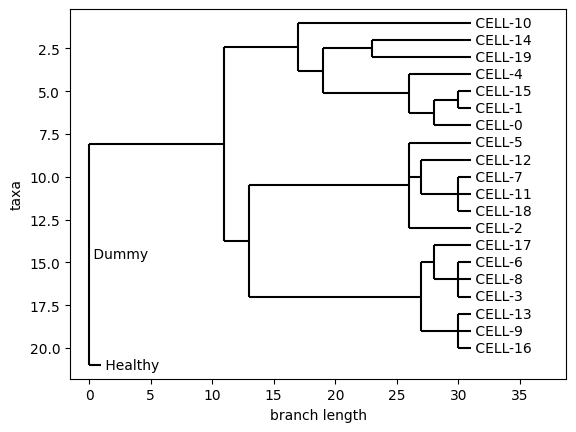

Saved to ./data/cellphy_simulated_set.phy
AT|AC|CC|CC|GA|AA|AT|CG|AT|GC|CG|AG|TT|AT|AT|AA|TG|CG|TT|CG|GG|TG|GC|GC|GG|CA|AA|TT|CT|CT|CT|GG|AT|CT|CG|CG|CT|AC|GG|GG|AA|CT|GA|CC|AT|GG|GC|TG|AT|CA|AT|GG|CA|TT|CC|CA|GA|GC|CC|CT|GC|GC|CG|AG|AT|AA|CT|CA|CG|CT|TG|GG|AA|GC|CC|TA|CG|CA|GG|GG|TT|GG|TG|CC|TT|AT|CT|GG|CG|CT|GG|GC|CG|TT|GG|CG|AA|AA|AA|TT|GC|GC|AG|TG|TT|AT|AT|CT|GA|CG|GC|GG|TA|CC|CT|TT|AA|CA|TT|TT|CT|CC|TG|GC|GC|AA|CG|AG|CT|AT|AA|GG|CC|AT|GC|AT|CT|GG|AA|GG|GG|CT|TG|TG|TT|GC|AT|CT|CG|AA|CA|AT|GG|CT|CT|GC|AT|CC|AT|AA|GG|GG|TT|TT|CG|TG|CA|CT|CC|TT|TA|CG|CC|TC|AT|GC|GG|TG|AA|AT|CG|GG|CC|CA|CC|CT|CG|CC|GC|AA|CG|CT|TT|GC|CG|CG|TT|TT|CT|GG|AT|CC|CG|AA|CA|CT|CG|AT|CT|GG|TG|CG|CT|AA|AT|CT|AT|TT|GG|AT|GC|TT|TG|GG|AT|CA|AT|GG|AT|CC|AG|CT|CG|CT|TT|AT|TT|TT|GA|TT|AT|CT|GC|GG|AT|GG|GG|TT|GT|TT|GC|CT|GC|GG|AA|AG|AT|GG|TT|GA|GG|AA|CA|GG|TG|TT|CA|CA|GG|GG|CC|CC|CT|GC|CT|CT|CC|CC|CA|CC|AT|TT|TC|CA|TG|GG|AC|TC|AT|CA|AT|GG|GC|CG|TT|GG|CG|GC|CA|CT|GG|CA|CG|CA|CT|CA|AT|CG|CG|GC|TG|TC|CT|GC|AT|CG|CG|TG|CC|G

In [6]:
exchangeability = np.random.uniform(0.03, 0.06, 6)
stationary = np.random.uniform(0, 1, 16)
# exchangeability = np.array([0.01, 0.02] * 3)
# stationary = np.ones(16)
# stationary[0] = 1.5
# stationary[3] = 1.5

print(f"exchangeability: {exchangeability}")
print(f"stationary: {stationary}")

dot_phy_path = "./data/cellphy_simulated_set.phy"

simulation = Simulate_GT16(exchangeability, stationary, sim_steps=30)

print(f"Newick tree: {simulation.newick_tree}")

tree = Phylo.read(io.StringIO(str(simulation.newick_tree)), "newick")
Phylo.draw(tree)
plt.show()

simulation.save_to_dot_phy(dot_phy_path)
print(f"Saved to {dot_phy_path}")

for cell in [simulation.healthy_cell] + simulation.leaf_cells:
    print(cell.get_human_readable_value())